# YOLOv3 Crater Detection and Degradation State Classifier Workflow
---
### Giles Matthews

In [ ]:
!nvidia-smi

## Setup

Clone the GitHub repo and install the requirements.txt file.

Having done this you are usually prompted to restart the runtime - do this using the prompt provided or by following:

    taskbar > Runtime > Restart runtime > Yes

Or use ```Ctrl + M .```

Re-import the necessary modules every runtime by running the appropriate cell below.

To access the datasets, please ensure this google drive folder is mounted:

https://drive.google.com/drive/folders/1Qh7VHt_dTZc8v0tYdSZlXo3cwTmxnYCI?usp=sharing

In [ ]:
print("---  Cloning repository  ---\n")
! git clone https://github.com/acse-gcm20/YOLOv3-CDA
print("\n---  Installing dependencies  ---\n")
! pip install -r /content/YOLOv3-CDA/requirements.txt
print("\nNow restart the Runtime before proceeding")

In [ ]:
# Run this cell every runtime
%cd /content/YOLOv3-CDA

import os
import torch

from pytorchyolo.train import run
from pytorchyolo.test import test
from pytorchyolo.detect import detect_directory

from src.utils import *

import sort_dataset

plt.rcParams.update({'font.size': 11})

/content/YOLOv3-CDA


## Data Organisation

In [ ]:
# Extract unaugmented Robbins data from google drive
%%capture
! unzip /content/drive/MyDrive/CDA/processed_Robbins.zip -d ./data/Robbins

In [ ]:
# Extract smaller sample of just mine and Yinze's images from google drive
# This smaller dataset is used to generate the 'Half Robbins' dataset
%%capture
! unzip /content/drive/MyDrive/CDA/small_Robbins.zip -d data/Robbins

In [ ]:
# Extract Benedix data from google drive
%%capture
! unzip /content/drive/MyDrive/CDA/Benedix.zip -d data/Benedix

Use the Dataset class in sort_dataset.py to generate the appropriate dataset for the classifier. Use the following parameters to generate each of the datasets.

Dataset Name | .zip file | Threshold | Clean
-------------|-----------|-----------|-------
Full Robbins | processed_Robbins.zip | 1 | False
Half Robbins | small_Robbins.zip | 0.5 | False
Clean Robbins | processed_Robbins.zip | 1 | True

In [ ]:
threshold = 1
clean = False
robbins = sort_dataset.Dataset('data/Robbins/crater_dictionary.csv', 'data/Robbins/loss_rank.csv', threshold, 'data/Robbins/classifier/', 'data/Robbins/crater_group_dataset/', clean=clean)

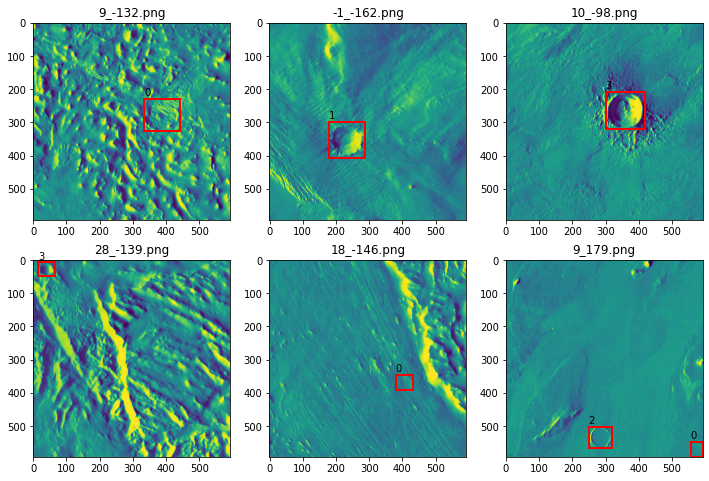

In [ ]:
# Examples of the Robbins training set
# Note the labels are zero-indexed
plot_image_dir('data/Robbins/classifier/images/', 'data/Robbins/classifier/labels/', label=True, save_path='clean_plot.pdf')

In [ ]:
# Perform augmentation on Robbins subset
! python src/aug.py --dataset 'data/Robbins/classifier' --id

imgs = os.listdir('data/Robbins/classifier/images/')
lbls = os.listdir('data/Robbins/classifier/labels/')
print(f'{len(imgs)} images, {len(lbls)} labels')

100% 139/139 [00:14<00:00,  9.82it/s]
556 images, 556 labels


Split the dataset into training, validation and test sets. Write the file paths for the model from the datasets generated previously.

In [ ]:
# Organise classified Robbins data into training, validation and test sets

# Classified Robbins images
imageFolder = '/content/YOLOv3-CDA/data/Robbins/classifier/images/'
labelFolder = "/content/YOLOv3-CDA/data/Robbins/classifier/labels/"

pathsFile = "/content/YOLOv3-CDA/data/all.txt"
trainFile = "/content/YOLOv3-CDA/data/train.txt"
valFile = "/content/YOLOv3-CDA/data/valid.txt"
testFile = "/content/YOLOv3-CDA/data/test.txt"

# Walk through image folder and write paths to all.txt, also count number of files
with open(pathsFile, "w") as all:
    n = 0
    for filename in os.listdir(imageFolder):
        all.write(imageFolder+filename+"\n")
        n += 1

# 90% of data into training set
trainSize = int(n * 0.9)
# 10% of training set into validation set
valSize = int(trainSize * 0.1)
trainSize -= valSize
# 10% of data into test set
testSize = n - (trainSize + valSize)

# Ensure dataset sizes are correct
try:
    assert n == trainSize + valSize + testSize
    print("Total images:", n, "\nTraining Size:", trainSize, "\nValidation Size:", valSize, "\nTest Size:", testSize)
except:
    print("Invalid Split")

# Get random indices lists according to dataset sizes
train_idx, val_idx, test_idx = torch.utils.data.random_split(range(n), [trainSize, valSize, testSize], generator=torch.Generator().manual_seed(42))

Total images: 12160 
Training Size: 9850 
Validation Size: 1094 
Test Size: 1216


In [ ]:
# Organise image path files

# Get list of all image paths
with open(pathsFile, "r") as paths:
    pathsList = paths.readlines()

# Store train/val/test paths as lists
trainList = [pathsList[i].rstrip('\n') for i in train_idx]
valList = [pathsList[i].rstrip('\n') for i in val_idx]
testList = [pathsList[i].rstrip('\n') for i in test_idx]

# Write path lists to files
list_to_file([trainList], trainFile)
list_to_file([valList], valFile)
list_to_file([testList], testFile)

print("Training paths:\t\t", trainFile, "\nValidation paths:\t", valFile, "\nTest paths:\t\t", testFile)

Training paths:		 /content/YOLOv3-CDA/data/train.txt 
Validation paths:	 /content/YOLOv3-CDA/data/valid.txt 
Test paths:		 /content/YOLOv3-CDA/data/test.txt


## Training

In [ ]:
# Darknet backbone pretrained on ImageNet
darknet = '/content/drive/MyDrive/CDA/weights/darknet53.conv.74'

# Run training sequence
run('models/classifier.cfg', 50, config='config/classifier.data', pretrained_weights=darknet)

In [ ]:
# Copy weights to google drive
!cp checkpoints/yolov3_ckpt_50.pth /content/drive/MyDrive/CDA/weights/yolov3_ckpt_50.pth

In [ ]:
# Copy stats to google drive
!cp stats.txt /content/drive/MyDrive/CDA/stats/yolov3_ckpt_50.txt 

In [ ]:
plot_stats('stats.txt')

## Detections

In [ ]:
# Move clean test set to new directory
list_file_2_dir('data/clean_test.txt', 'data/test_set/')

In [ ]:
weights = 'checkpoints/yolov3_ckpt_50.pth'
directory = 'data/test_set/images/'

detect_directory('models/classifier.cfg', weights, directory, ['1', '2', '3', '4'], 'output/classifier/', n_cpu=2, conf_thres=0.2)

In [ ]:
comparison_plot('data/test_set/images/', 'data/test_set/labels', 'output/classifier/labels', 3)

## Testing

In [ ]:
test('models/classifier.cfg', 'checkpoints/yolov3_ckpt_50.pth', 'config/classifier.data', 'data/clean_test.txt')